In [118]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datetime import datetime as dt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import tensorflow as tf


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sunspots/Sunspots.csv


# Topic - Can we use machine learning to predict sun spots?

Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.
 
We will be using DNN and RNN to predict the sun spots and compare the result 

# Data

The data set is available on Kaggle under the name sunspots. The most updated version of data can be found on National Oceanic and Atmospheric Administration. This data set contain sunspot number from 1749 to July 2018, which is enough data for machine to detect pattern. 

In [119]:
sunspots = pd.read_csv("/kaggle/input/sunspots/Sunspots.csv", index_col=0)
print(sunspots.head())
print(sunspots.shape)

         Date  Monthly Mean Total Sunspot Number
0  1749-01-31                               96.7
1  1749-02-28                              104.3
2  1749-03-31                              116.7
3  1749-04-30                               92.8
4  1749-05-31                              141.7
(3265, 2)


In [120]:
sunspots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               3265 non-null   object 
 1   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), object(1)
memory usage: 76.5+ KB


In [139]:
print(sunspots.describe())

             value
count  3265.000000
mean     81.778775
std      67.889277
min       0.000000
25%      23.900000
50%      67.200000
75%     122.500000
max     398.200000
missing data
date     0
value    0
dtype: int64


In [140]:
print('missing data')
print(sunspots.isnull().sum())

missing data
date     0
value    0
dtype: int64


I don't like the column names, so I will change them to something easier to deal with

In [160]:
sunspots.rename({"Monthly Mean Total Sunspot Number": "value", "Date": "date"}, axis=1, inplace=True)

# EDA

### Histogram
Visualize the frequency distribution of monthly mean of total sunspots

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

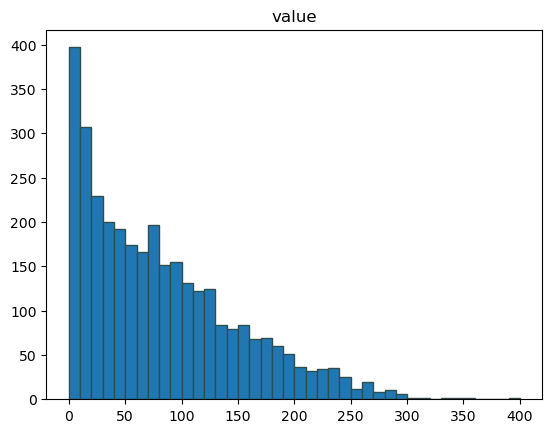

In [161]:
bins=np.arange(0,401,10)
sunspots.hist(bins=bins, edgecolor = 'darkslategrey', grid = False)

### Scatter Plot
Explore the relationship between each observations 


<AxesSubplot:>

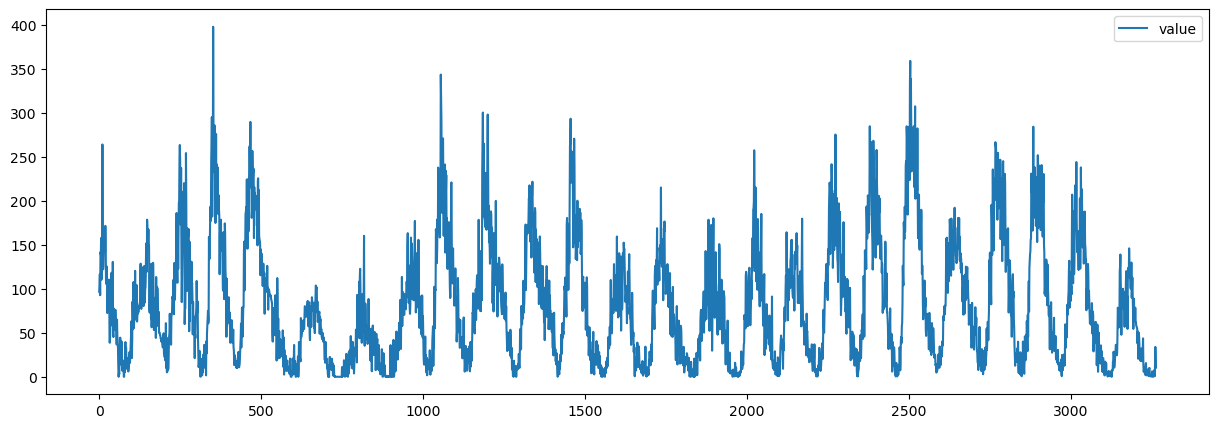

In [189]:
sunspots.plot(figsize = (15,5))

### Autocorrelation Plot
Visually see the seasonality of the solar cycle

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

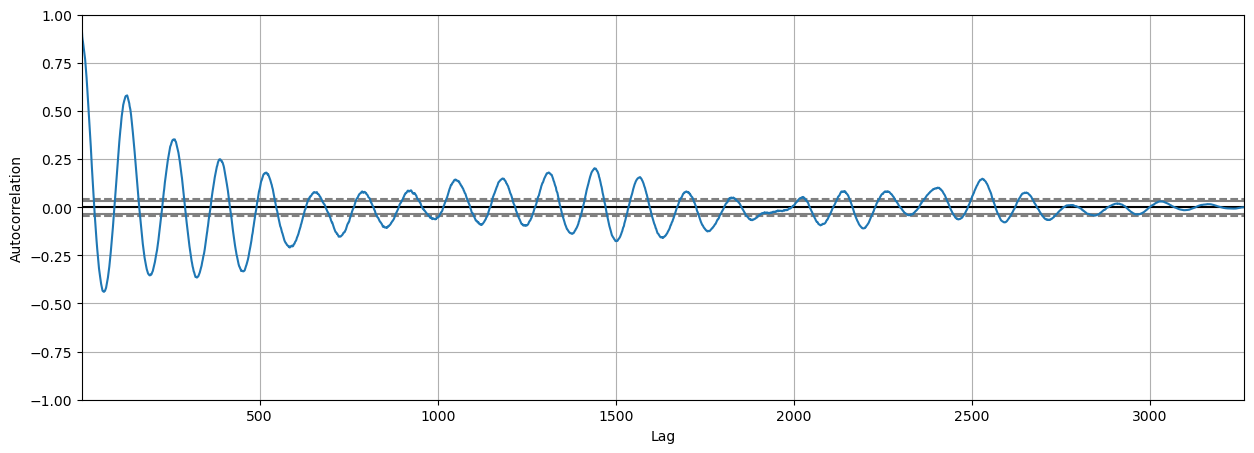

In [190]:
plt.figure(figsize = (15,5))
pd.plotting.autocorrelation_plot(sunspots['value'].to_numpy())

## Rolling Average
Trend of the solar cycle

<AxesSubplot:>

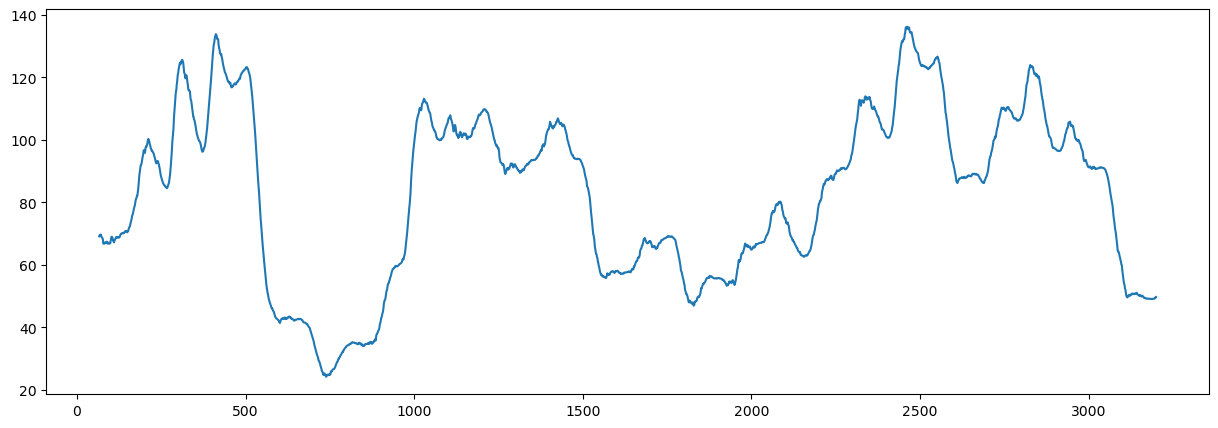

In [186]:
rolling_avg = sunspots['value'].rolling(window = 12*11, closed = 'both', center =  True).mean()
rolling_avg.plot(figsize = (15,5))

For time serie data, we can't not randomly select data points for test and train. Since there are 3265 data points, I will select 3000 points for train and the rest for test. The ultimate goal for time series prediction is to prediction future, and the data points that's closer the prediction weights more, so we will include the validation set as the training set once we found a good model. The testing set will become the data gathered from the future. 

Tensor also worked better with numpy than panda, so we will convert the data to numpy as well

In [123]:
# Convert pd to numpy
series = sunspots['value'].to_numpy()
time = sunspots['date'].to_numpy()

# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]


# Helper Functions

## Windowed Training

It take the dataset and partition it into subsections. Time serie prediction is different from regular regression. In regular regression, we typically use x to predict y. In time series prediction we really are using the previous y to predict the next y, so how far away the previous y should have different impact on the predicting y. 

In [124]:
def windowed_training(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Windowed Validation
The functionwill window the validation set and return the prediction fo

In [125]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    
    return forecast

## Plot series

In [126]:
def plot_series(x, y, format="-", start=0, end, title, xlabel, ylabel, legend):

    plt.figure(figsize=(10, 6))
    plt.plot(x[start:end], y[start:end], format)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# graph_mae_loss

In [127]:
def plot_mae_loss(mae, loss):
    # Get mae and loss from history log
    mae=rnn_history.history['mae']
    loss=rnn_history.history['loss']

    # Get number of epochs
    epochs=range(len(loss)) 

    # Plot mae and loss
    plot_series(
        x=epochs, 
        y=(mae, loss), 
        title='MAE and Loss', 
        xlabel='MAE',
        ylabel='Loss',
        legend=['MAE', 'Loss']
        )

    # Only plot the last 80% of the epochs
    zoom_split = int(epochs[-1] * 0.2)
    epochs_zoom = epochs[zoom_split:]
    mae_zoom = mae[zoom_split:]
    loss_zoom = loss[zoom_split:]

    # Plot zoomed mae and loss
    plot_series(
        x=epochs_zoom, 
        y=(mae_zoom, loss_zoom), 
        title='Last 80 % MAE and Loss', 
        xlabel='MAE',
        ylabel='Loss',
        legend=['MAE', 'Loss']
        )

# Parameters

In [192]:
# Parameters
WINDOW_SIZE = 15
BATCH_SIZE = 32
SHUFFLE_SIZE = 1000
EPOCHS =100
INITIAL_LR = .0001

# Generate the dataset windows
train_set = windowed_training(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_SIZE)

# Model 1
### A basic 3 layer dense neural network


In [212]:
# Build the model
knn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(15, input_shape=[WINDOW_SIZE], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
knn.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 15)                240       
                                                                 
 dense_53 (Dense)            (None, 10)                160       
                                                                 
 dense_54 (Dense)            (None, 1)                 11        
                                                                 
Total params: 411
Trainable params: 411
Non-trainable params: 0
_________________________________________________________________


In [213]:
optimizer = tf.keras.optimizers.SGD(learning_rate=INITIAL_LR, momentum=0.9)
# Set the training parameters
knn.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
knn_history = knn.fit(train_set,epochs=EPOCHS, verbose = 0)

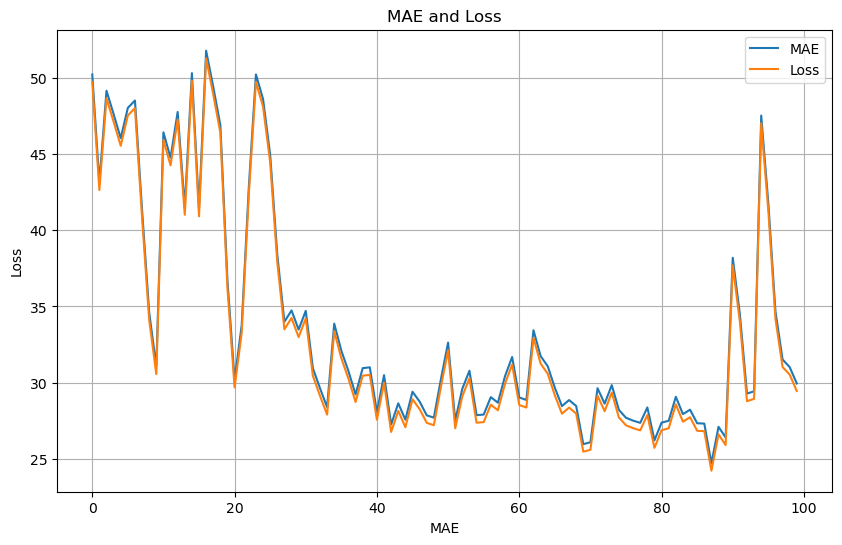

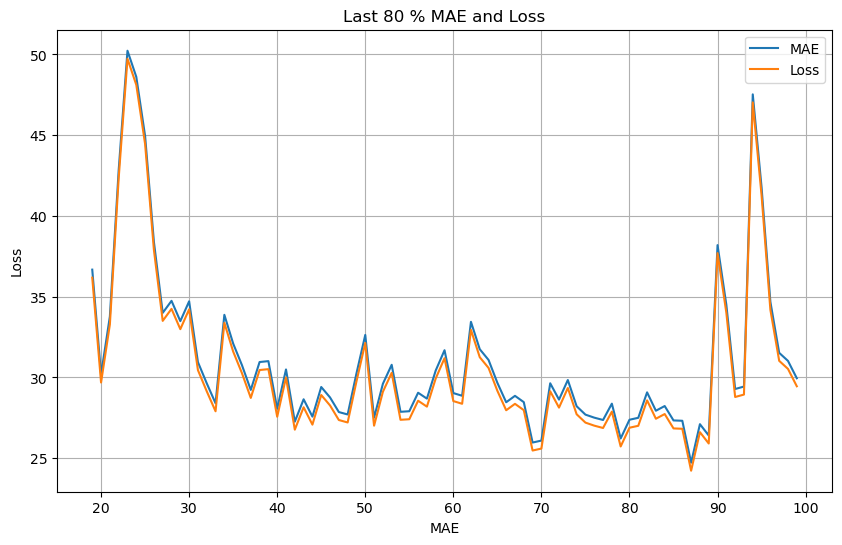

In [215]:
knn_mae = knn_history.history['mae']
Knn_loss = knn_history.history['loss']
plot_mae_loss(knn_mae, Knn_loss)

9/9 [==============================] - 0s 8ms/step


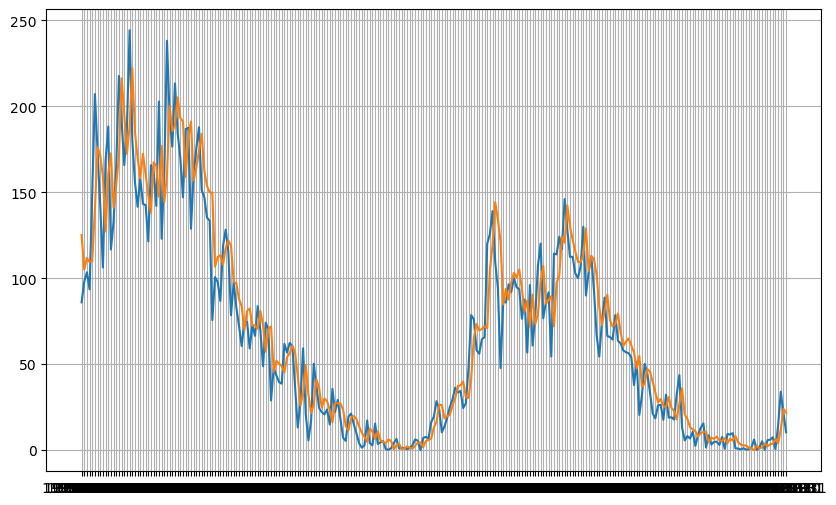

In [214]:
# Reduce the original series
forecast_series = series[split_time-WINDOW_SIZE:-1]

# Use helper function to generate predictions
forecast = model_forecast(knn, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [197]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

15.959947


# Model 2

In [198]:
tf.keras.backend.clear_session()

# Build the Model
rnn = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[WINDOW_SIZE]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
rnn.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_14 (Lambda)          (None, 15, 1)             0         
                                                                 
 simple_rnn_36 (SimpleRNN)   (None, 15, 40)            1680      
                                                                 
 simple_rnn_37 (SimpleRNN)   (None, 40)                3240      
                                                                 
 dense_36 (Dense)            (None, 1)                 41        
                                                                 
 lambda_15 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [199]:
optimizer = tf.keras.optimizers.SGD(learning_rate=INITIAL_LR, momentum=0.9)
rnn.compile(loss=tf.keras.losses.Huber(),
            optimizer=optimizer,
            metrics=["mae"])
rnn_history = rnn.fit(train_set,epochs=EPOCHS, verbose = 0)

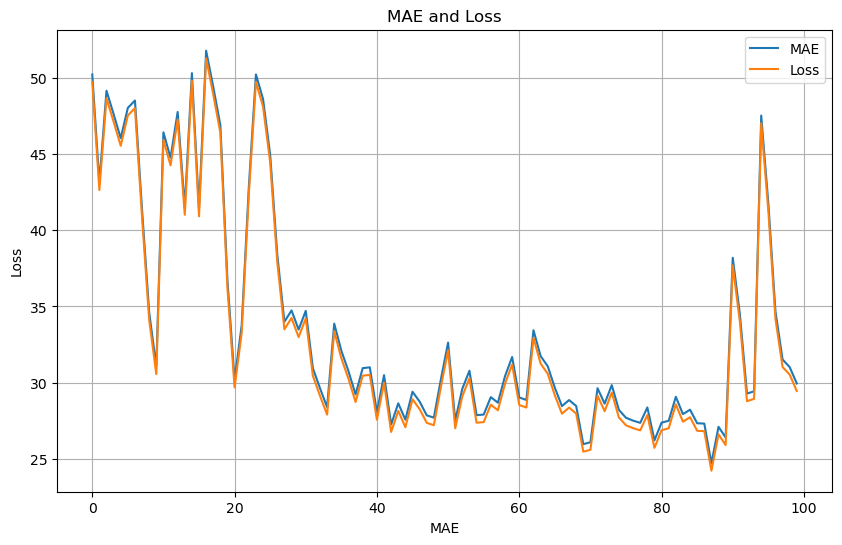

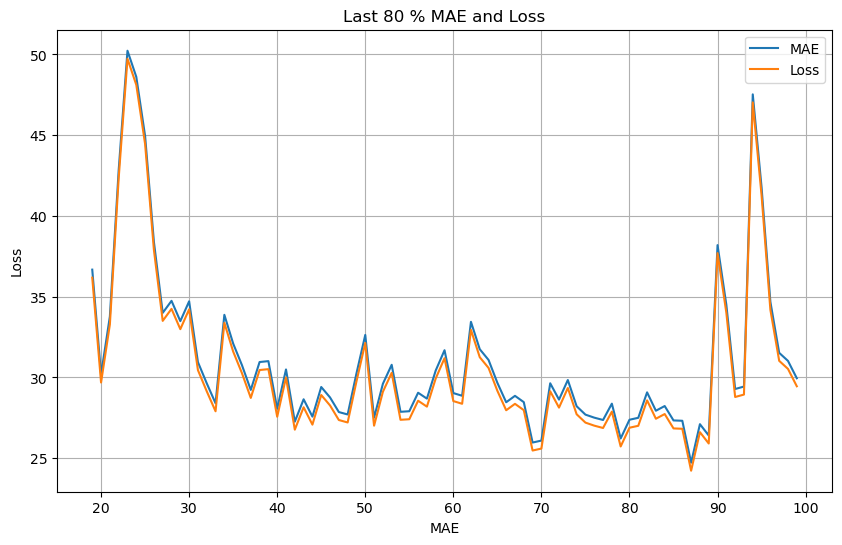

In [217]:
# Get mae and loss from history log
rnn_mae=rnn_history.history['mae']
rnn_loss=rnn_history.history['loss']
plot_mae_loss(rnn_mae, rnn_loss)

9/9 [==============================] - 0s 9ms/step


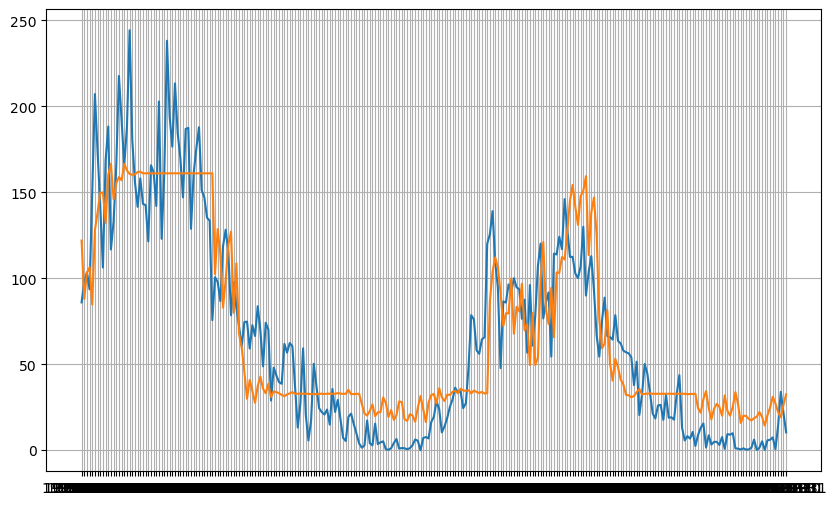

In [201]:
# Reduce the original series
forecast_series = series[split_time-WINDOW_SIZE:-1]

# Use helper function to generate predictions
forecast = model_forecast(rnn, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [202]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

21.397104


# Model 3 LSTM

In [218]:
tf.keras.backend.clear_session()

# The model
lstm = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[WINDOW_SIZE]),
  tf.keras.layers.LSTM(40, return_sequences=True),
  tf.keras.layers.LSTM(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 15, 1)             0         
                                                                 
 lstm (LSTM)                 (None, 15, 40)            6720      
                                                                 
 lstm_1 (LSTM)               (None, 40)                12960     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 19,721
Trainable params: 19,721
Non-trainable params: 0
_________________________________________________________________


In [220]:
optimizer = tf.keras.optimizers.SGD(learning_rate=INITIAL_LR, momentum=0.9)
lstm.compile(loss=tf.keras.losses.Huber(),
            optimizer=optimizer,
            metrics=["mae"])
lstm_history = lstm.fit(train_set,epochs=EPOCHS, verbose = 0)

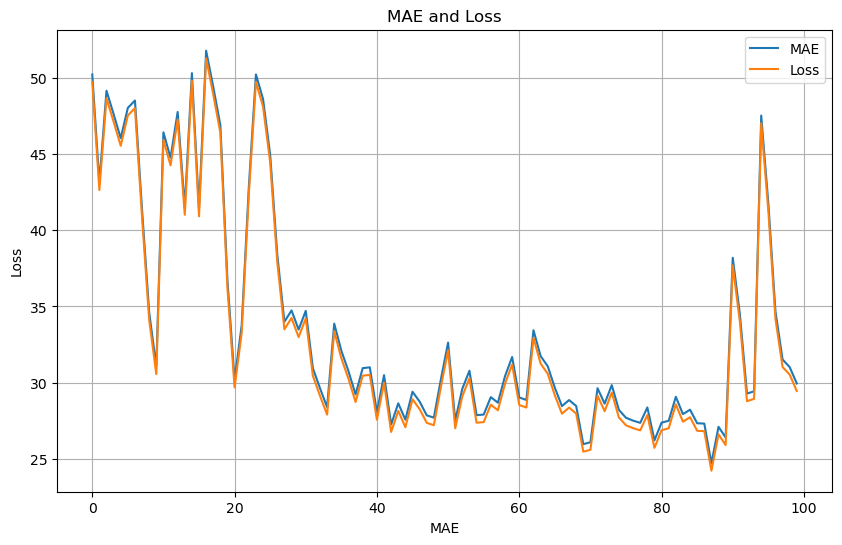

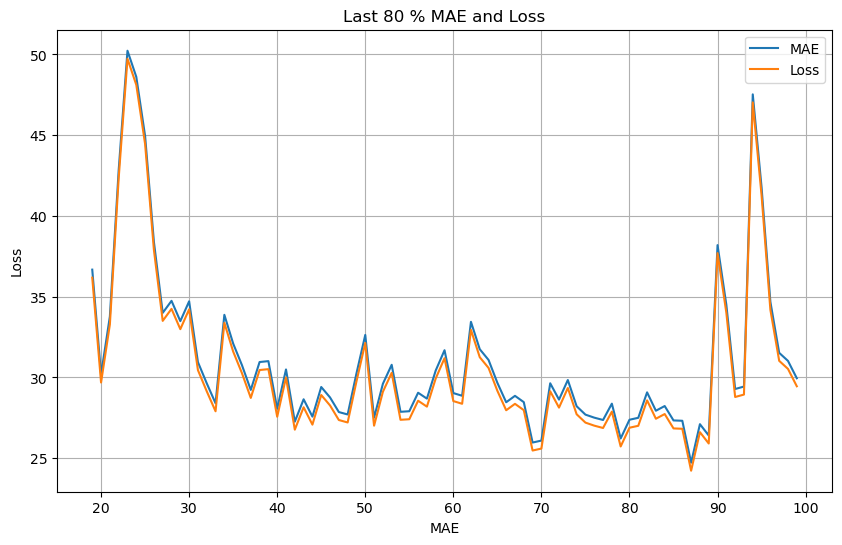

In [221]:
# Get mae and loss from history log
lstm_mae = lstm_history.history['mae']
lstm_loss = lstm_history.history['loss']
plot_mae_loss(lstm_mae, lstm_loss)

9/9 [==============================] - 1s 12ms/step


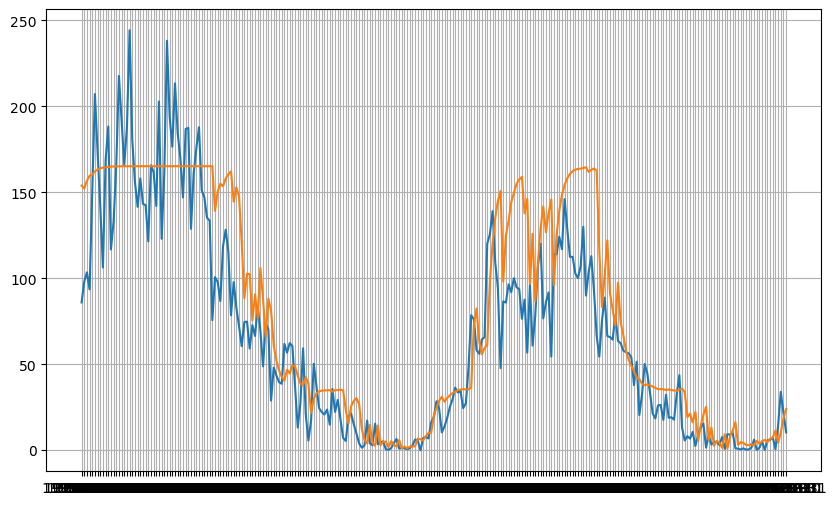

In [222]:
# Reduce the original series
forecast_series = series[split_time-WINDOW_SIZE:-1]

# Use helper function to generate predictions
forecast = model_forecast(lstm, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

# Optimizer Tuning
In the above example, KNN outpreformed RNN and LSTM. It is obvious that we are running into vanishing exploding gradients in some places. Professor Geena gave us a list of way to remedy this problem. We will be using learning rate scheduler to resolve this problem. 

### RNN Model

In [203]:
# Build the Model
rnn_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[WINDOW_SIZE]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
rnn_tune.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_28 (Lambda)          (None, 15, 1)             0         
                                                                 
 simple_rnn_50 (SimpleRNN)   (None, 15, 40)            1680      
                                                                 
 simple_rnn_51 (SimpleRNN)   (None, 40)                3240      
                                                                 
 dense_49 (Dense)            (None, 1)                 41        
                                                                 
 lambda_29 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [204]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = rnn_tune.fit(train_set, epochs=EPOCHS, callbacks=[lr_schedule], verbose=0)

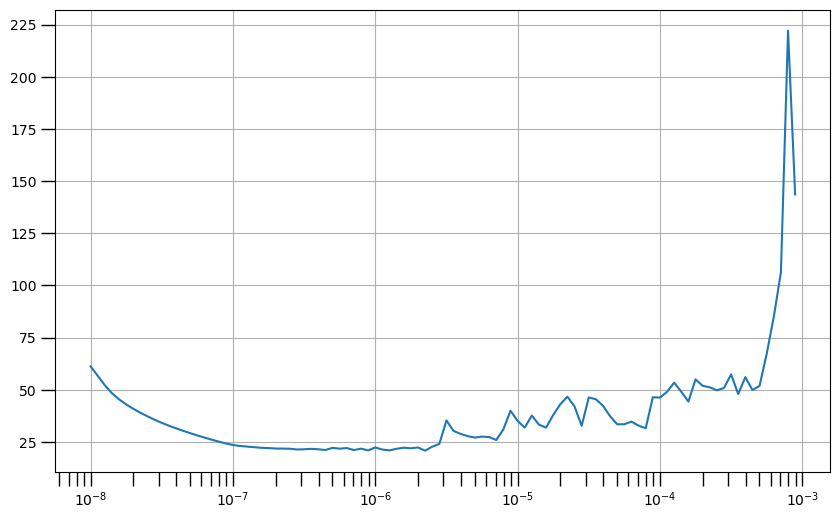

In [205]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(EPOCHS) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')


From the above graph, we can see the best learning rate is around 8e-7

In [207]:
# Build the Model
rnn_model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[WINDOW_SIZE]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
rnn_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

rnn_model_history = rnn_model.fit(train_set,epochs=EPOCHS, verbose=0)

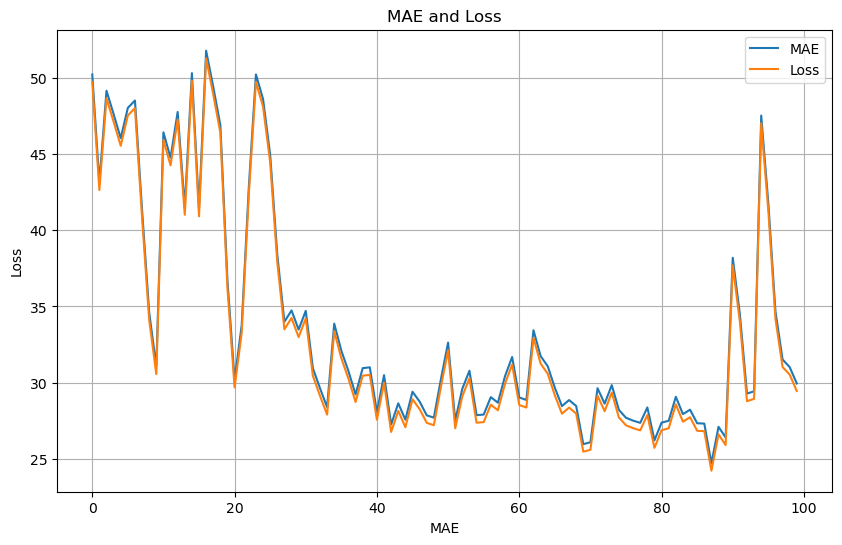

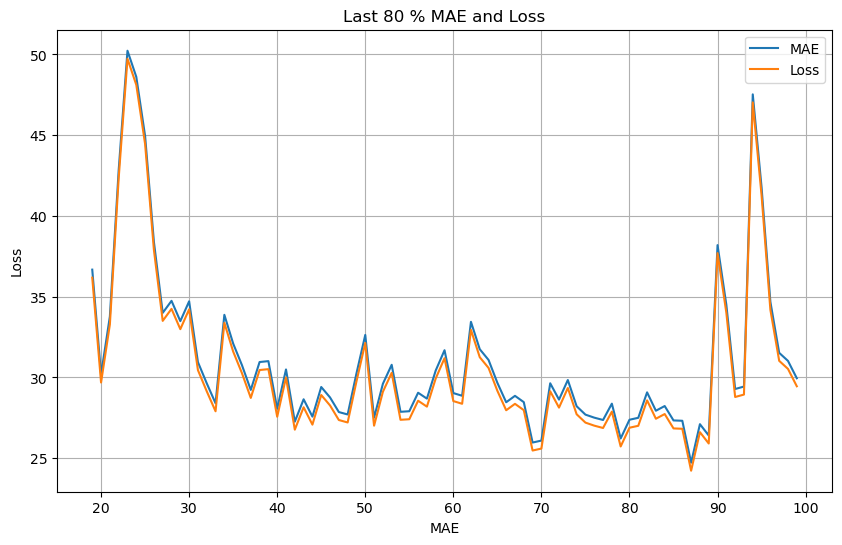

In [208]:
# Get mae and loss from history log
rnn_model_mae=rnn_model_history.history['mae']
rnn_model_loss=rnn_model_history.history['loss']
plot_mae_loss(rnn_model_mae, rnn_model_loss)

9/9 [==============================] - 0s 9ms/step


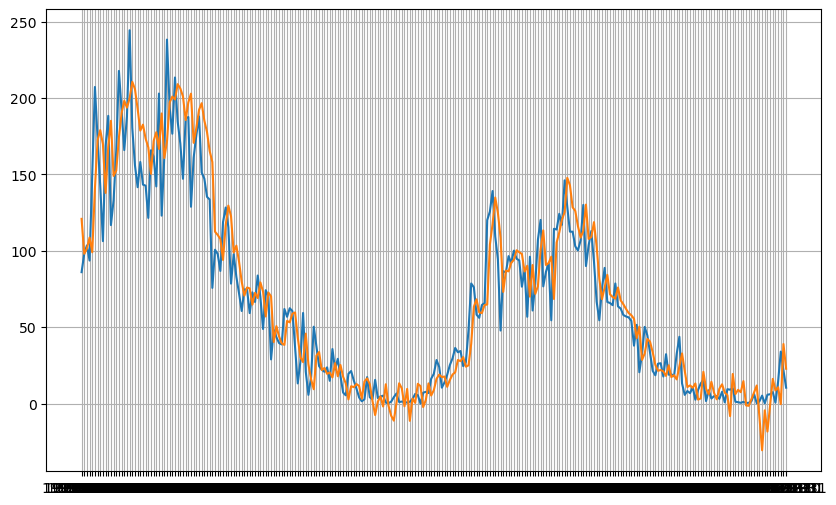

In [209]:
# Reduce the original series
forecast_series = series[split_time-WINDOW_SIZE:-1]

# Use helper function to generate predictions
forecast = model_forecast(rnn_model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [210]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

15.674783


### LSTM Model

In [225]:
tf.keras.backend.clear_session()

# The model
lstm_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[WINDOW_SIZE]),
  tf.keras.layers.LSTM(40, return_sequences=True),
  tf.keras.layers.LSTM(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

lstm_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 15, 1)             0         
                                                                 
 lstm (LSTM)                 (None, 15, 40)            6720      
                                                                 
 lstm_1 (LSTM)               (None, 40)                12960     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 19,721
Trainable params: 19,721
Non-trainable params: 0
_________________________________________________________________


In [226]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
lstm_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = lstm_tune.fit(train_set, epochs=EPOCHS, callbacks=[lr_schedule], verbose=0)

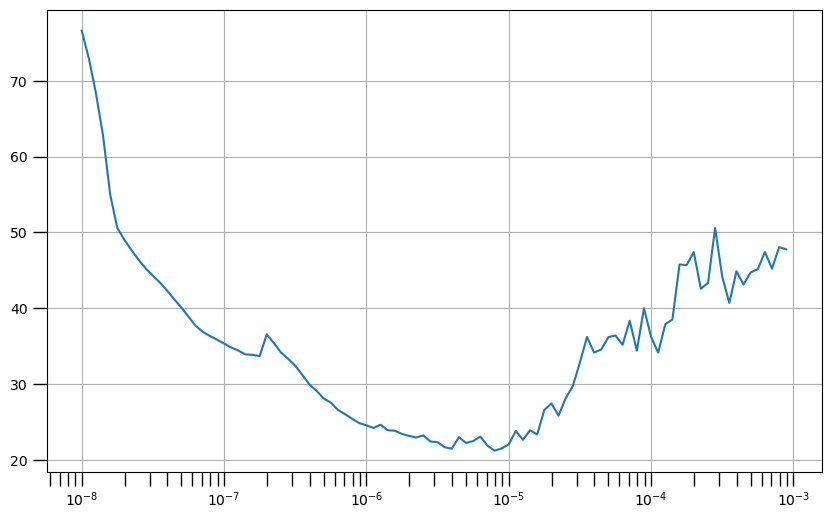

In [227]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(EPOCHS) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

From the above graph we see that the optimal learning rate is around 8e-6

In [228]:
# Build the Model
lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[WINDOW_SIZE]),
  tf.keras.layers.LSTM(40, return_sequences=True),
  tf.keras.layers.LSTM(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 8e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
lstm_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

lstm_model_history = lstm_model.fit(train_set,epochs=EPOCHS, verbose=0)


9/9 [==============================] - 1s 12ms/step


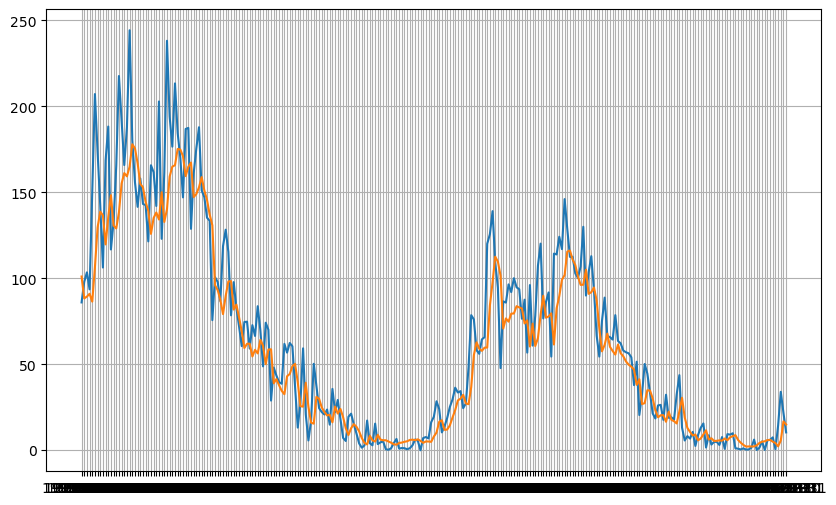

In [229]:
# Reduce the original series
forecast_series = series[split_time-WINDOW_SIZE:-1]

# Use helper function to generate predictions
forecast = model_forecast(lstm_model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [230]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.362249


# Conclusion

In this notebook, I used 3 models to predict a time serie data. Model 1 is comprised of dense layer, model 2 uses simple rnn, and model 3 uses lstm. All three model did fairly well predicting the sunspot. Model 1 had MAE score of 15.959947 without tuning. Model 2 had 15.674783 after tuning the learning rate and Model 3 had 14.362249 with learning rate tuned. It was important to tune the rnn model because the learning rate was causing problems to the model making some places flat and causing extra errors. I could have use Adam Optimzer, but I would lose some learning opportunites, thus I choose to use GDA to experience the vanishing/exploding gradient. It made the note book much more interesting.

The idea of windowing was also very interesting, one way to look at time series is like using linear regression. However, we have to predict the y variable using different ys. The windowing divided the data into subsets that lead to the y that we are interested in. The original data can't be shuffled because it will lose it sequence property, but we can shuffl windows to make the training data less bias. 

# Discussion

The models that I created were very simple, I could have created more complex model such as adding convolution layer or make the network deeper to increase the preformance. Another thing that I could have done was to use different optimizer. I was using Adam Optimzer at the begining, and the model actually fit better. 

I was surprised how well the dense neural network did without any tuning. It is very simple to use compare to RNN. However I'm sure once the data gets bigger or the layers gets complex, it will not preform as well as the RNN model.